In [ ]:
## This file is to preprocess and load data

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

import seaborn as sns
sns.set_style()
sns.set_context("talk")
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the business json file
business_path = 'yelp_dataset/yelp_academic_dataset_business.json'
business = pd.read_json(business_path,lines=True)

In [3]:
# Check the fields in business
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None


In [4]:
# Dropping businesses which are not open
business = business.loc[business['is_open']==1]

In [5]:
# Check the top 10 cities represented in our dataset
business["city"].value_counts()[:10]

Las Vegas     25043
Phoenix       16305
Toronto       14962
Charlotte      8500
Scottsdale     7341
Calgary        6772
Pittsburgh     6107
Mesa           5482
Montréal       5367
Henderson      4293
Name: city, dtype: int64

In [6]:
# To restrict and limit the size of data, let us stick to Las Vegas only
business = business.loc[business['city'] == 'Las Vegas']

In [7]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
6,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,1,"{'BusinessParking': '{'garage': False, 'street...","Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ..."
51,5XMKDYmMGSKkCkrYoELxzg,Annette Thomas Hair Colorist Specialist,"101 S Rainbow Blvd, Ste 23, Darby's Hairitage",Las Vegas,NV,89107,36.172534,-115.244762,5.0,7,1,"{'GoodForKids': 'True', 'BusinessParking': '{'...","Hair Stylists, Hair Salons, Beauty & Spas",None


In [ ]:
# Drop the columns that we dont need
business = business.drop(['city','address', 'state', 'latitude', 'longitude', 'is_open','attributes','hours'], axis=1)

In [51]:
# Restricting to businesses with atleast 10 reviews
business = business.loc[business['review_count'] >= 10]

In [55]:
# Check the number of businesses we have in our datset now
business.shape

(15386, 6)

In [57]:
# Check the dataset
business.head(5)

,business_id,name,postal_code,stars,review_count,categories
6,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,89118,3.5,81,"Dry Cleaning & Laundry, Local Services, Laundr..."
66,bierVTEi44nJtFVQ01N-yQ,Lacoste Outlet Las Vegas,89106,3.5,11,"Accessories, Shopping, Fashion, Men's Clothing..."
78,FrMRHhzT-qUzv1-Nh1IOjQ,Sin City Party Buses,89118,4.0,18,"Hotels & Travel, Party Bus Rentals, Limos, Eve..."
86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,89109,4.5,11,"Food, Food Trucks, Restaurants, Pizza"
101,MTx-Zdl_KcU_z9G832XAjg,Taco Bell,89131,2.5,37,"Fast Food, Restaurants"


In [8]:
# Importing review json file in chunks, because of the super large size
review_json_path = 'yelp_dataset/yelp_academic_dataset_review.json'
size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,'text':str,'useful':int},
                      chunksize=size)

In [9]:
review

In [10]:
# With help from: 
#https://towardsdatascience.com/converting-yelp-dataset-to-csv-using-pandas-2a4c8f03bd88

chunk_list = []
for chunk_review in review:
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(business, chunk_review, on='business_id', how='inner')
    # Show feedback on progress
    print(f"{chunk_merged.shape[0]} out of {size:,} related reviews")
    chunk_list.append(chunk_merged)
# After trimming down the review file, concatenate all relevant data back to one dataframe
df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

263232 out of 1,000,000 related reviews
257926 out of 1,000,000 related reviews
269003 out of 1,000,000 related reviews
254226 out of 1,000,000 related reviews
264068 out of 1,000,000 related reviews
266846 out of 1,000,000 related reviews
248374 out of 1,000,000 related reviews
260298 out of 1,000,000 related reviews
6036 out of 1,000,000 related reviews


In [11]:
# df is our new dataset with data about restaurants and their corresponding reviews
df.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,categories,hours,review_id,user_id,review_stars,useful,funny,cool,text,date
0,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,...,"Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",9bMxu3-RCv0ncYnNNNkbWg,IMguz1Z9dp8HG0UfeLEdEg,5,3,0,1,I've been coming to this dry cleaner for almos...,2016-06-23 05:50:54
1,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,...,"Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",b-B3ycJZmOTP5EdWTwCsMA,_TAVpa1Y2_5KZ5wWYeX_6g,1,1,0,0,They lost 2 pairs of my suitpants and told me ...,2011-10-27 23:35:10
2,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,...,"Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",MaIIb4Er_LuqN3zSSdA06w,45R6BBybzwDuJaL08d1myQ,5,1,0,0,I have been going to this dry cleaning since I...,2013-07-13 03:25:04
3,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,...,"Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",RALKX860sppIq-oxsSFhqQ,7iziCsP2MkHMmckpYVPSDg,1,4,1,1,I've only had my dry cleaning done here twice ...,2016-06-23 01:58:09
4,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,...,"Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",zmueCMXpF3v2Gz2Szxq01g,Yg08tRMxm0eaL-rXyNIAHw,5,3,1,1,After reading the reviews of the cleaners clos...,2012-09-12 20:38:40


In [12]:
# Checking number of rows our dataframe has
df.shape

(2090009, 22)

In [13]:
# We can drop reviews which did not recieve any useful votes, to restrict our data further
df = df.loc[df['useful'] > 0]

In [1]:
# We will now restrict to a certain set of reviews, based on review length, we will look for the length which is most common

In [14]:
# Create columns to store lenght of reviews written
df['reviewlen'] = df['text'].str.len()

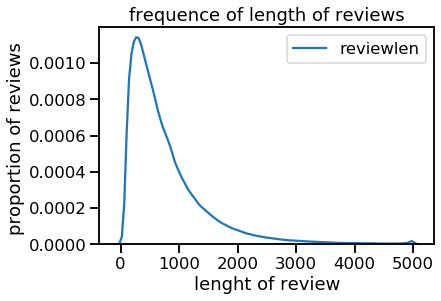

In [15]:
# Visualizing distribution of lenght of reviews
sns.kdeplot(df['reviewlen'])
plt.title('frequence of length of reviews')
plt.xlabel("lenght of review")
plt.ylabel("proportion of reviews ");

In [16]:
# We can restrict our analysis to reviews with length less than 1000
df = df.loc[df['reviewlen'] < 1000]

In [17]:
df.shape

(679949, 23)

In [18]:
# Save data to CSV file for future use
csv_name = "review_and_business_data_cleaned_withdate.csv"
df.to_csv(csv_name, index=False)

In [2]:
# Now we process the user-json file
# Importing user-json file in chunks, because of the super large size
user_json_path = 'yelp_dataset/yelp_academic_dataset_user.json'
size = 100000
user = pd.read_json(user_json_path, lines=True,chunksize=size)

In [3]:
# The following cell was used in a separate notebook to extract unique users, and saved in a csv
# List of users who made to our refined dataset
# users_in_filtered_dataset = df["user_id"].unique()

In [5]:
unique_user = pd.read_csv('unique_users.csv')

In [6]:
users_in_filtered_dataset = unique_user['unique_user']

In [7]:
# Number of unique users
users_in_filtered_dataset.shape

(285258,)

In [3]:
# We are ONLY importing users from the user json file, 
# whose reviews made it to our above shortlisted dataset of businesses

In [8]:
chunk_list_user = []
for chunk_user in user:

    # Filter out users that made to our refined dataset
    chunk_user1 = chunk_user[chunk_user['user_id'].isin(users_in_filtered_dataset)]
    # Show feedback on progres
    print("Iteration successful")
    chunk_list_user.append(chunk_user1)

# After trimming down the review file, concatenate all relevant data back to one dataframe
user_df = pd.concat(chunk_list_user, ignore_index=True, join='outer', axis=0)

Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful
Iteration successful


In [12]:
# Storing the user_df into a csv for future use. user_df is the data from the user json file
user_df.head()

user_df.to_csv('unique_user_df.csv', index=False)